# Bottom Temperature for the SOE
https://noaa-edab.github.io/catalog/bottom_temp_comp.html

In [1]:
# import relevant packages
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import regionmask
import READ_EDAB_Utilities_py as reupy
import copernicusmarine
import numpy as np
import os
import pandas as pn
from datetime import datetime

Load datasets

In [2]:
# Load mom6 data
mom6_bt_cropped = xr.open_dataset('mom6_bt_cropped.nc')

In [3]:
mom6_bt_cropped

<xarray.Dataset> Size: 177MB
Dimensions:  (lon: 477, lat: 287, time: 324)
Coordinates:
  * lon      (lon) float64 4kB 261.6 261.6 261.7 261.8 ... 299.8 299.9 300.0
  * lat      (lat) float64 2kB 30.05 30.12 30.18 30.24 ... 47.87 47.93 48.0
  * time     (time) datetime64[ns] 3kB 1993-01-16T12:00:00 ... 2019-12-16T12:...
Data variables:
    tob      (time, lat, lon) float32 177MB ...
Attributes:
    NumFilesInSet:       1
    title:               NWA12_COBALT_2023_04_kpo4-coastatten-physics
    associated_files:    areacello: 19930101.ocean_static.nc
    grid_type:           regular
    grid_tile:           N/A
    external_variables:  areacello
    history:             Derived and written at NOAA Physical Science Laboratory
    NCO:                 netCDF Operators version 5.0.1 (Homepage = http://nc...
    contact:             chia-wei.hsu@noaa.gov
    dataset:             regional mom6 regrid

In [4]:
# Load Hubert's debiased ROMS + GLORYS dataset
directory = "C:/Users/Laura.Gruenburg/Desktop/Projects/MOM6_Validation/bt_hubert/bt_revised_metadata_032024/"

bt = xr.open_dataset(directory + 'bottom_temp_1959.nc')

# Iterate over files in directory
for file in os.listdir(directory):
    filename = directory + file
    bt_yr = xr.open_dataset(directory + file)
    bt = xr.merge([bt, bt_yr])

In [5]:
# Get monthly means
bt_monthly = bt.resample(time = 'MS').mean()

In [6]:
# Load in the shapefile
epu = gpd.read_file('EPU_shape/EPU_NOESTUARIES.shp')

In [7]:
# Specify the EPUs
mab = epu[epu.EPU == 'MAB']
gom = epu[epu.EPU == 'GOM']
gb = epu[epu.EPU == 'GB']

In [8]:
# Subset mom6 data to only within each EPU
mab_m6 = reupy.crop_nd(mom6_bt_cropped, 'lon', 'lat', mab)
gom_m6 = reupy.crop_nd(mom6_bt_cropped, 'lon', 'lat', gom)
gb_m6 = reupy.crop_nd(mom6_bt_cropped, 'lon', 'lat', gb)

# subset Hubert's data to only within each EPU
mab_hp = reupy.crop_nd(bt_monthly, 'longitude', 'latitude', mab)
gom_hp = reupy.crop_nd(bt_monthly, 'longitude', 'latitude', gom)
gb_hp = reupy.crop_nd(bt_monthly, 'longitude', 'latitude', gb)

In [18]:
# NEW CLIMATOLOGY as of 12/11/2024 1991-2020 or whatvere part of that your time series has
mab_m6_clim = mab_m6.sel(time = slice('1991-01-01', '2020-12-31')).resample(time = 'QS-JAN').mean().groupby('time.month').mean('time')
gom_m6_clim = gom_m6.sel(time = slice('1991-01-01', '2020-12-31')).resample(time = 'QS-JAN').mean().groupby('time.month').mean('time')
gb_m6_clim = gb_m6.sel(time = slice('1991-01-01', '2020-12-31')).resample(time = 'QS-JAN').mean().groupby('time.month').mean('time')

In [9]:
# NEW CLIMATOLOGY as of 12/11/2024 1991-2020 or whatvere part of that your time series has
mab_hp_clim = mab_hp.sel(time = slice('1991-01-01', '2020-12-31')).resample(time = 'QS-JAN').mean().groupby('time.month').mean('time')
gom_hp_clim = gom_hp.sel(time = slice('1991-01-01', '2020-12-31')).resample(time = 'QS-JAN').mean().groupby('time.month').mean('time')
gb_hp_clim = gb_hp.sel(time = slice('1991-01-01', '2020-12-31')).resample(time = 'QS-JAN').mean().groupby('time.month').mean('time')

In [11]:
#seasonal averages
seasonal_mab_m6 = mab_m6.resample(time = 'QS-JAN').mean()
seasonal_gom_m6 = gom_m6.resample(time = 'QS-JAN').mean()
seasonal_gb_m6 = gb_m6.resample(time = 'QS-JAN').mean()

seasonal_mab_hp = mab_hp.resample(time = 'QS-JAN').mean()
seasonal_gom_hp = gom_hp.resample(time = 'QS-JAN').mean()
seasonal_gb_hp = gb_hp.resample(time = 'QS-JAN').mean()

#annual averages
mab_m6_yearly = mab_m6.groupby('time.year').mean('time').mean(['lat','lon'])
gom_m6_yearly = gom_m6.groupby('time.year').mean('time').mean(['lat','lon'])
gb_m6_yearly = gb_m6.groupby('time.year').mean('time').mean(['lat','lon'])

mab_hp_yearly = mab_hp.groupby('time.year').mean('time').mean(['latitude','longitude'])
gom_hp_yearly = gom_hp.groupby('time.year').mean('time').mean(['latitude','longitude'])
gb_hp_yearly = gb_hp.groupby('time.year').mean('time').mean(['latitude','longitude'])

In [16]:
def seasonal_anomalies(input_data, temp_variable, climatology,lat_var, lon_var):
    winter = input_data[temp_variable][input_data.time.dt.month == 1] - climatology[temp_variable][climatology.month == 1]
    spring = input_data[temp_variable][input_data.time.dt.month == 4] - climatology[temp_variable][climatology.month == 4]
    summer = input_data[temp_variable][input_data.time.dt.month == 7] - climatology[temp_variable][climatology.month == 7]
    fall = input_data[temp_variable][input_data.time.dt.month == 10] - climatology[temp_variable][climatology.month == 10]
    return(winter.mean([lat_var,lon_var]), spring.mean([lat_var,lon_var]), summer.mean([lat_var,lon_var]), fall.mean([lat_var,lon_var]))
            

In [19]:
# seasonal anomalies
winter_mab, spring_mab, summer_mab, fall_mab = seasonal_anomalies(seasonal_mab_m6, 'tob', mab_m6_clim, 'lat', 'lon')
winter_gom, spring_gom, summer_gom, fall_gom = seasonal_anomalies(seasonal_gom_m6, 'tob', gom_m6_clim, 'lat', 'lon')
winter_gb, spring_gb, summer_gb, fall_gb = seasonal_anomalies(seasonal_gb_m6, 'tob', gb_m6_clim, 'lat', 'lon')

In [20]:
# seasonal anomalies
winter_mab_hp, spring_mab_hp, summer_mab_hp, fall_mab_hp = seasonal_anomalies(seasonal_mab_hp, 'sea_water_temperature_at_sea_floor', mab_hp_clim, 'latitude', 'longitude')
winter_gom_hp, spring_gom_hp, summer_gom_hp, fall_gom_hp = seasonal_anomalies(seasonal_gom_hp, 'sea_water_temperature_at_sea_floor', gom_hp_clim, 'latitude', 'longitude')
winter_gb_hp, spring_gb_hp, summer_gb_hp, fall_gb_hp = seasonal_anomalies(seasonal_gb_hp, 'sea_water_temperature_at_sea_floor', gb_hp_clim, 'latitude', 'longitude')

In [24]:
def data_frame(wint, sp, su, fall, annual_values, EPU):
    BTw = pn.DataFrame(data = {'Time': wint.time.dt.year,
                            'Value': np.squeeze(wint.values),
                            'EPU': [EPU]*27,
                            'Source': ['MOM6']*27,
                            'Var': ['Winter Bottom Temp Anomaly']*27,
                            'Units': ['degrees C']*27})
    BTsp = pn.DataFrame(data = {'Time': sp.time.dt.year,
                            'Value': np.squeeze(sp.values),
                            'EPU': [EPU]*27,
                            'Source': ['MOM6']*27,
                            'Var': ['Spring Bottom Temp Anomaly']*27,
                            'Units': ['degrees C']*27})
    BTsu = pn.DataFrame(data = {'Time': su.time.dt.year,
                            'Value': np.squeeze(su.values),
                            'EPU': [EPU]*27,
                            'Source': ['MOM6']*27,
                            'Var': ['Summer Bottom Temp Anomaly']*27,
                            'Units': ['degrees C']*27})
    BTf = pn.DataFrame(data = {'Time': fall.time.dt.year,
                            'Value': np.squeeze(fall.values),
                            'EPU': [EPU]*27,
                            'Source': ['MOM6']*27,
                            'Var': ['Fall Bottom Temp Anomaly']*27,
                            'Units': ['degrees C']*27})
    BT_annual = pn.DataFrame(data = {'Time': annual_values.year,
                                     'Value': np.squeeze(annual_values.values),
                                     'EPU': [EPU]*27,
                                     'Source': ['MOM6']*27,
                                     'Var': ['Annual Bottom Temp']*27,
                                     'Units': ['degrees C']*27})
    BT = pn.concat([BTw, BTsp, BTsu, BTf, BT_annual])
    return(BT)

In [25]:
BT_mab = data_frame(winter_mab, spring_mab, summer_mab, fall_mab, mab_m6_yearly.tob, 'MAB') 
BT_gom = data_frame(winter_gom, spring_gom, summer_gom, fall_gom, gom_m6_yearly.tob, 'GOM')
BT_gb = data_frame(winter_gb, spring_gb, summer_gb, fall_gb, gb_m6_yearly.tob, 'GB')

BT = pn.concat([BT_mab, BT_gom, BT_gb])

In [26]:
BT = BT.reset_index(drop = True)

In [105]:
BT.to_csv('BT_m6_soe_2024.csv')

In [36]:
def data_frame_hp(wint, sp, su, fall, annual_values, EPU):
    BTw = pn.DataFrame(data = {'Time': wint.time.dt.year,
                            'Value': np.squeeze(wint.values),
                            'EPU': [EPU]*63,
                            'Source': ['GLORYS']*63,
                            'Var': ['Winter Bottom Temp Anomaly']*63,
                            'Units': ['degrees C']*63})
    BTsp = pn.DataFrame(data = {'Time': sp.time.dt.year,
                            'Value': np.squeeze(sp.values),
                            'EPU': [EPU]*62,
                            'Source': ['GLORYS']*62,
                            'Var': ['Spring Bottom Temp Anomaly']*62,
                            'Units': ['degrees C']*62})
    BTsu = pn.DataFrame(data = {'Time': su.time.dt.year,
                            'Value': np.squeeze(su.values),
                            'EPU': [EPU]*62,
                            'Source': ['GLORYS']*62,
                            'Var': ['Summer Bottom Temp Anomaly']*62,
                            'Units': ['degrees C']*62})
    BTf = pn.DataFrame(data = {'Time': fall.time.dt.year,
                            'Value': np.squeeze(fall.values),
                            'EPU': [EPU]*62,
                            'Source': ['GLORYS']*62,
                            'Var': ['Fall Bottom Temp Anomaly']*62,
                            'Units': ['degrees C']*62})
    BT_annual = pn.DataFrame(data = {'Time': annual_values.year,
                                     'Value': np.squeeze(annual_values.values),
                                     'EPU': [EPU]*63,
                                     'Source': ['GLORYS']*63,
                                     'Var': ['Annual Bottom Temp']*63,
                                     'Units': ['degrees C']*63})
    BT = pn.concat([BTw, BTsp, BTsu, BTf, BT_annual])
    return(BT)

In [37]:
BT_mab_hp = data_frame_hp(winter_mab_hp, spring_mab_hp, summer_mab_hp, fall_mab_hp, mab_hp_yearly.sea_water_temperature_at_sea_floor, 'MAB') 
BT_gom_hp = data_frame_hp(winter_gom_hp, spring_gom_hp, summer_gom_hp, fall_gom_hp, gom_hp_yearly.sea_water_temperature_at_sea_floor, 'GOM')
BT_gb_hp = data_frame_hp(winter_gb_hp, spring_gb_hp, summer_gb_hp, fall_gb_hp, gb_hp_yearly.sea_water_temperature_at_sea_floor, 'GB')

BT_hp = pn.concat([BT_mab_hp, BT_gom_hp, BT_gb_hp])

Text(0.5, 0.98, 'Winter Bottom Temperature Anomaly')

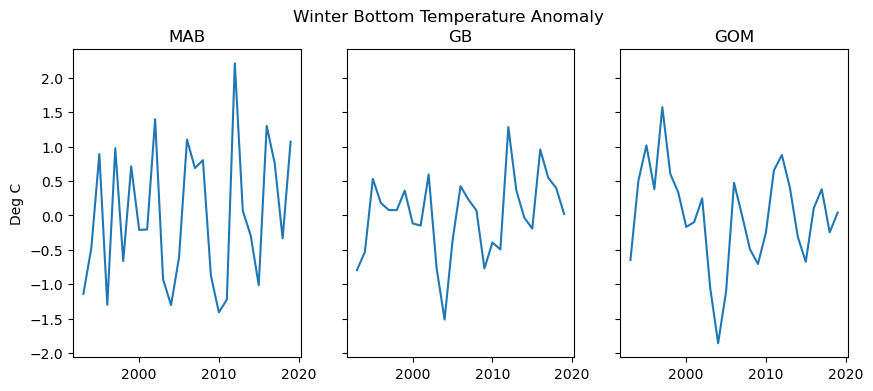

In [35]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Winter Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Winter Bottom Temp Anomaly')].Value)
ax[0].set_title('MAB')
ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Winter Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Winter Bottom Temp Anomaly')].Value)
ax[1].set_title('GB')
ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Winter Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Winter Bottom Temp Anomaly')].Value)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Winter Bottom Temperature Anomaly')


Text(0.5, 0.98, 'Winter Bottom Temperature Anomaly')

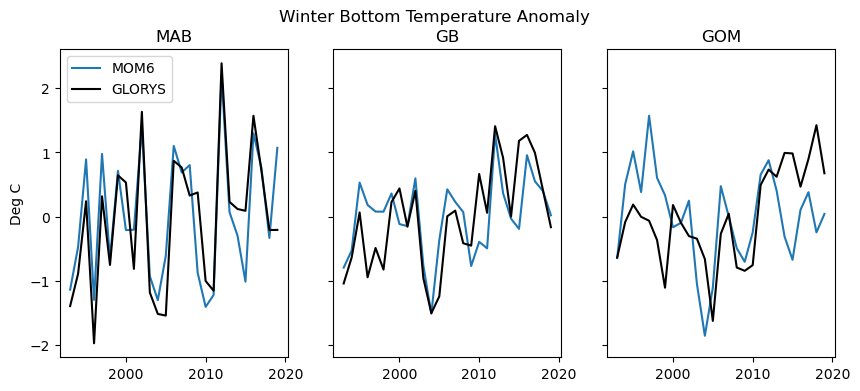

In [44]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Winter Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Winter Bottom Temp Anomaly')].Value, label = 'MOM6')
ax[0].plot(BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Winter Bottom Temp Anomaly')].Time[-29:-2], BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Winter Bottom Temp Anomaly')].Value[-29:-2], 'k', label = 'GLORYS')
ax[0].set_title('MAB')
ax[0].legend()

ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Winter Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Winter Bottom Temp Anomaly')].Value)
ax[1].plot(BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Winter Bottom Temp Anomaly')].Time[-29:-2], BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Winter Bottom Temp Anomaly')].Value[-29:-2], 'k', label = 'GLORYS')
ax[1].set_title('GB')

ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Winter Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Winter Bottom Temp Anomaly')].Value)
ax[2].plot(BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Winter Bottom Temp Anomaly')].Time[-29:-2], BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Winter Bottom Temp Anomaly')].Value[-29:-2], 'k', label = 'GLORYS')
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Winter Bottom Temperature Anomaly')

Text(0.5, 0.98, 'Spring Bottom Temperature Anomaly')

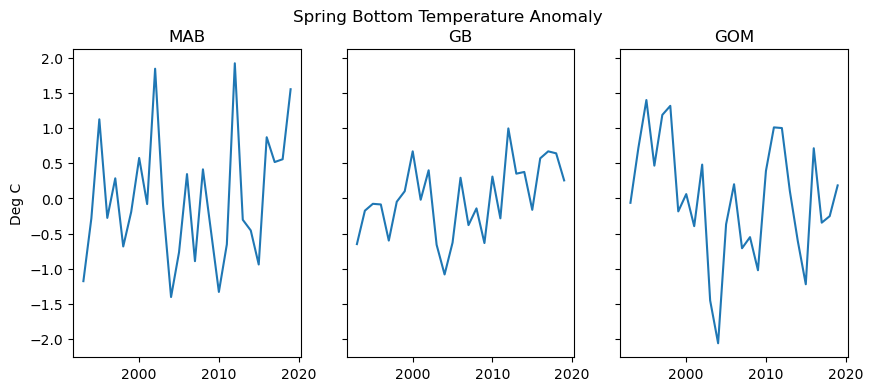

In [37]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Spring Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Spring Bottom Temp Anomaly')].Value)
ax[0].set_title('MAB')
ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Spring Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Spring Bottom Temp Anomaly')].Value)
ax[1].set_title('GB')
ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Spring Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Spring Bottom Temp Anomaly')].Value)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Spring Bottom Temperature Anomaly')


Text(0.5, 0.98, 'Spring Bottom Temperature Anomaly')

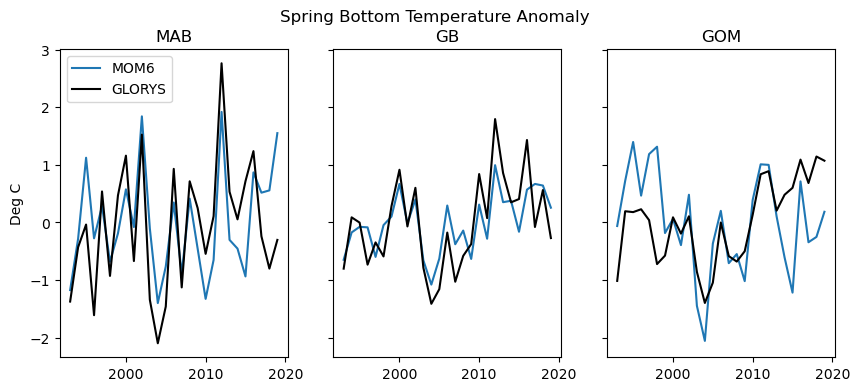

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Spring Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Spring Bottom Temp Anomaly')].Value, label = 'MOM6')
ax[0].plot(BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Spring Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Spring Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[0].set_title('MAB')
ax[0].legend()

ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Spring Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Spring Bottom Temp Anomaly')].Value)
ax[1].plot(BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Spring Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Spring Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[1].set_title('GB')

ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Spring Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Spring Bottom Temp Anomaly')].Value)
ax[2].plot(BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Spring Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Spring Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Spring Bottom Temperature Anomaly')

Text(0.5, 0.98, 'Fall Bottom Temperature Anomaly')

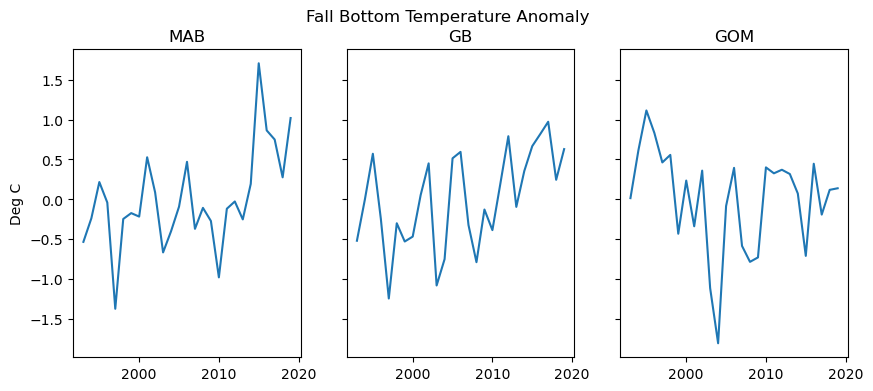

In [38]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Fall Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Fall Bottom Temp Anomaly')].Value)
ax[0].set_title('MAB')
ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Fall Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Fall Bottom Temp Anomaly')].Value)
ax[1].set_title('GB')
ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Fall Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Fall Bottom Temp Anomaly')].Value)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Fall Bottom Temperature Anomaly')


Text(0.5, 0.98, 'Fall Bottom Temperature Anomaly')

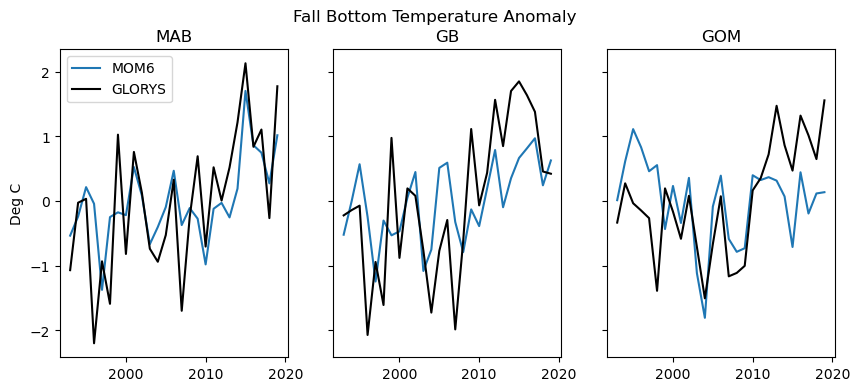

In [47]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Fall Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Fall Bottom Temp Anomaly')].Value, label = 'MOM6')
ax[0].plot(BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Fall Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Fall Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[0].set_title('MAB')
ax[0].legend()

ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Fall Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Fall Bottom Temp Anomaly')].Value)
ax[1].plot(BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Fall Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Fall Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[1].set_title('GB')

ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Fall Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Fall Bottom Temp Anomaly')].Value)
ax[2].plot(BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Fall Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Fall Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Fall Bottom Temperature Anomaly')

Text(0.5, 0.98, 'Summer Bottom Temperature Anomaly')

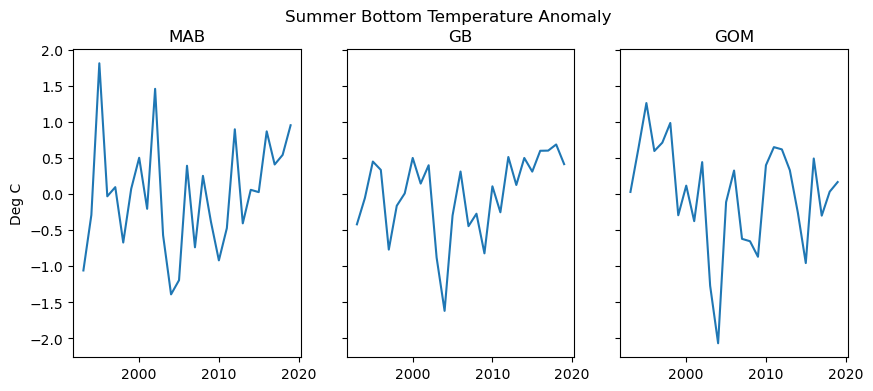

In [39]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Summer Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Summer Bottom Temp Anomaly')].Value)
ax[0].set_title('MAB')
ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Summer Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Summer Bottom Temp Anomaly')].Value)
ax[1].set_title('GB')
ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Summer Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Summer Bottom Temp Anomaly')].Value)
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Summer Bottom Temperature Anomaly')

Text(0.5, 0.98, 'Summer Bottom Temperature Anomaly')

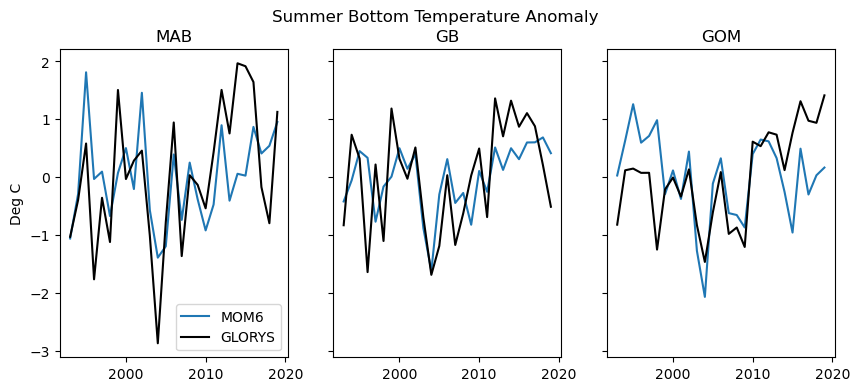

In [49]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Summer Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Summer Bottom Temp Anomaly')].Value, label = 'MOM6')
ax[0].plot(BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Summer Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Summer Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[0].set_title('MAB')
ax[0].legend()

ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Summer Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Summer Bottom Temp Anomaly')].Value)
ax[1].plot(BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Summer Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Summer Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[1].set_title('GB')

ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Summer Bottom Temp Anomaly')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Summer Bottom Temp Anomaly')].Value)
ax[2].plot(BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Summer Bottom Temp Anomaly')].Time[-28:-1], BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Summer Bottom Temp Anomaly')].Value[-28:-1], 'k', label = 'GLORYS')
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Summer Bottom Temperature Anomaly')

Text(0.5, 0.98, 'Annual Bottom Temperature')

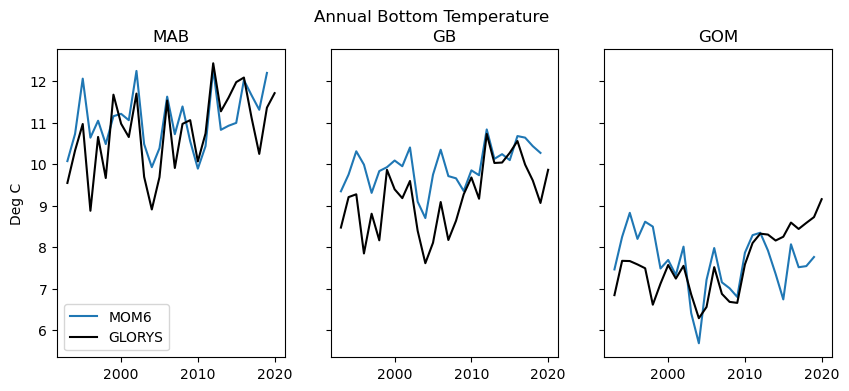

In [53]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = [10,4], sharey = True)
ax[0].plot(BT[(BT.EPU == 'MAB') & (BT.Var == 'Annual Bottom Temp')].Time, BT[(BT.EPU == 'MAB') & (BT.Var == 'Annual Bottom Temp')].Value, label = 'MOM6')
ax[0].plot(BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Annual Bottom Temp')].Time[-29:-1], BT_hp[(BT_hp.EPU == 'MAB') & (BT_hp.Var == 'Annual Bottom Temp')].Value[-29:-1], c = 'k', label = 'GLORYS')
ax[0].set_title('MAB')
ax[0].legend()
           
ax[1].plot(BT[(BT.EPU == 'GB') & (BT.Var == 'Annual Bottom Temp')].Time, BT[(BT.EPU == 'GB') & (BT.Var == 'Annual Bottom Temp')].Value)
ax[1].plot(BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Annual Bottom Temp')].Time[-29:-1], BT_hp[(BT_hp.EPU == 'GB') & (BT_hp.Var == 'Annual Bottom Temp')].Value[-29:-1], c = 'k', label = 'GLORYS')
ax[1].set_title('GB')
           
ax[2].plot(BT[(BT.EPU == 'GOM') & (BT.Var == 'Annual Bottom Temp')].Time, BT[(BT.EPU == 'GOM') & (BT.Var == 'Annual Bottom Temp')].Value)
ax[2].plot(BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Annual Bottom Temp')].Time[-29:-1], BT_hp[(BT_hp.EPU == 'GOM') & (BT_hp.Var == 'Annual Bottom Temp')].Value[-29:-1], c = 'k', label = 'GLORYS')
ax[2].set_title('GOM')

ax[0].set_ylabel('Deg C')
fig.suptitle('Annual Bottom Temperature')

In [40]:
BT

,Time,Value,EPU,Source,Var,Units
0,1993,-1.139061,MAB,MOM6,Winter Bottom Temp Anomaly,degrees C
1,1994,-0.471968,MAB,MOM6,Winter Bottom Temp Anomaly,degrees C
2,1995,0.891759,MAB,MOM6,Winter Bottom Temp Anomaly,degrees C
3,1996,-1.298188,MAB,MOM6,Winter Bottom Temp Anomaly,degrees C
4,1997,0.976554,MAB,MOM6,Winter Bottom Temp Anomaly,degrees C
...,...,...,...,...,...,...
400,2015,10.098589,GB,MOM6,Annual Bottom Temp,degrees C
401,2016,10.678293,GB,MOM6,Annual Bottom Temp,degrees C
402,2017,10.640535,GB,MOM6,Annual Bottom Temp,degrees C
403,2018,10.435130,GB,MOM6,Annual Bottom Temp,degrees C


In [99]:
#BT.write_csv('BT_m6_2024.csv')

AttributeError: module 'pandas' has no attribute 'write_csv'

In [ ]:
# seasonal averages
seasonal_avg_mab_hp_m6_ts = mab_hp_m6_ts.resample(time = 'QS-JAN').mean()
winters_mab_hp_m6_ts = seasonal_avg_mab_hp_m6_ts.tob[np.arange(0,244,4)]
springs_mab_hp_m6_ts = seasonal_avg_mab_hp_m6_ts.tob[np.arange(1,244,4)]
summers_mab_hp_m6_ts = seasonal_avg_mab_hp_m6_ts.tob[np.arange(2,244,4)]
falls_mab_hp_m6_ts = seasonal_avg_mab_hp_m6_ts.tob[np.arange(3,244,4)]

seasonal_avg_gb_hp_m6_ts = gb_hp_m6_ts.resample(time = 'QS-JAN').mean()
winters_gb_hp_m6_ts = seasonal_avg_gb_hp_m6_ts.tob[np.arange(0,244,4)]
springs_gb_hp_m6_ts = seasonal_avg_gb_hp_m6_ts.tob[np.arange(1,244,4)]
summers_gb_hp_m6_ts = seasonal_avg_gb_hp_m6_ts.tob[np.arange(2,244,4)]
falls_gb_hp_m6_ts = seasonal_avg_gb_hp_m6_ts.tob[np.arange(3,244,4)]

seasonal_avg_gom_hp_m6_ts = gom_hp_m6_ts.resample(time = 'QS-JAN').mean()
winters_gom_hp_m6_ts = seasonal_avg_gom_hp_m6_ts.tob[np.arange(0,244,4)]
springs_gom_hp_m6_ts = seasonal_avg_gom_hp_m6_ts.tob[np.arange(1,244,4)]
summers_gom_hp_m6_ts = seasonal_avg_gom_hp_m6_ts.tob[np.arange(2,244,4)]
falls_gom_hp_m6_ts = seasonal_avg_gom_hp_m6_ts.tob[np.arange(3,244,4)]

In [9]:
# Just the debiased roms
mab_hp_roms = mab_hp.sel(time = slice('1959-01-01', '1992-12-31'))
gb_hp_roms = gb_hp.sel(time = slice('1959-01-01', '1992-12-31'))
gom_hp_roms = gom_hp.sel(time = slice('1959-01-01', '1992-12-31'))

In [101]:
#average in lat/lon space
mab_hp_ts = mab_hp_roms.mean(['latitude','longitude'])
gb_hp_ts = gb_hp_roms.mean(['latitude','longitude'])
gom_hp_ts = gom_hp_roms.mean(['latitude','longitude'])

# average the model data in lat/lon space
mab_m6_ts = mab_m6.mean(['lat','lon'])
gom_m6_ts = gom_m6.mean(['lat','lon'])
gb_m6_ts = gb_m6.mean(['lat','lon'])

In [102]:
# make the temperature variable named the same thing as in the model
mab_hp_ts['tob'] = mab_hp_ts.sea_water_temperature_at_sea_floor
mab_hp_ts = mab_hp_ts.drop(['sea_water_temperature_at_sea_floor'])

gb_hp_ts['tob'] = gb_hp_ts.sea_water_temperature_at_sea_floor
gb_hp_ts = gb_hp_ts.drop(['sea_water_temperature_at_sea_floor'])

gom_hp_ts['tob'] = gom_hp_ts.sea_water_temperature_at_sea_floor
gom_hp_ts = gom_hp_ts.drop(['sea_water_temperature_at_sea_floor'])

C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\609390418.py:3: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  mab_hp_ts = mab_hp_ts.drop(['sea_water_temperature_at_sea_floor'])
C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\609390418.py:6: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  gb_hp_ts = gb_hp_ts.drop(['sea_water_temperature_at_sea_floor'])
C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\609390418.py:9: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  gom_hp_ts = gom_hp_ts.drop(['sea_water_temperature_at_sea_floor'])


In [103]:
# merger the two datasets
mab_hp_m6_ts = xr.merge([mab_hp_ts, mab_m6_ts])
gb_hp_m6_ts = xr.merge([gb_hp_ts, gb_m6_ts])
gom_hp_m6_ts = xr.merge([gom_hp_ts, gom_m6_ts])

In [104]:
# annual_averages
mab_m6_ts_annual = mab_m6_ts.groupby('time.year').mean('time')
gb_m6_ts_annual = gb_m6_ts.groupby('time.year').mean('time')
gom_m6_ts_annual = gom_m6_ts.groupby('time.year').mean('time')

In [105]:
# seasonal averages
seasonal_avg_mab_hp_m6_ts = mab_hp_m6_ts.resample(time = 'QS-JAN').mean()
winters_mab_hp_m6_ts = seasonal_avg_mab_hp_m6_ts.tob[np.arange(0,244,4)]
springs_mab_hp_m6_ts = seasonal_avg_mab_hp_m6_ts.tob[np.arange(1,244,4)]
summers_mab_hp_m6_ts = seasonal_avg_mab_hp_m6_ts.tob[np.arange(2,244,4)]
falls_mab_hp_m6_ts = seasonal_avg_mab_hp_m6_ts.tob[np.arange(3,244,4)]

seasonal_avg_gb_hp_m6_ts = gb_hp_m6_ts.resample(time = 'QS-JAN').mean()
winters_gb_hp_m6_ts = seasonal_avg_gb_hp_m6_ts.tob[np.arange(0,244,4)]
springs_gb_hp_m6_ts = seasonal_avg_gb_hp_m6_ts.tob[np.arange(1,244,4)]
summers_gb_hp_m6_ts = seasonal_avg_gb_hp_m6_ts.tob[np.arange(2,244,4)]
falls_gb_hp_m6_ts = seasonal_avg_gb_hp_m6_ts.tob[np.arange(3,244,4)]

seasonal_avg_gom_hp_m6_ts = gom_hp_m6_ts.resample(time = 'QS-JAN').mean()
winters_gom_hp_m6_ts = seasonal_avg_gom_hp_m6_ts.tob[np.arange(0,244,4)]
springs_gom_hp_m6_ts = seasonal_avg_gom_hp_m6_ts.tob[np.arange(1,244,4)]
summers_gom_hp_m6_ts = seasonal_avg_gom_hp_m6_ts.tob[np.arange(2,244,4)]
falls_gom_hp_m6_ts = seasonal_avg_gom_hp_m6_ts.tob[np.arange(3,244,4)]

In [106]:
#mab_hp_ts['tob'] = mab_hp_ts.sea_water_temperature_at_sea_floor
#mab_hp_ts = mab_hp_ts.drop(['sea_water_temperature_at_sea_floor'])
winters_mab_hp_m6_ts - winters_mab_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean()

<xarray.DataArray 'tob' (time: 61)> Size: 244B
array([-1.3596873e+00, -6.8338919e-01, -1.4556084e+00, -9.8172951e-01,
       -1.3165078e+00, -1.0275483e+00, -1.2909374e+00, -1.8985062e+00,
       -9.9474764e-01, -1.9747653e+00, -2.4423866e+00, -1.0270691e+00,
       -1.3160229e+00,  2.7370453e-04, -8.4665108e-01,  6.1644554e-01,
        2.2495747e-01,  4.7143269e-01, -2.5765481e+00, -9.0526915e-01,
       -1.1307015e+00, -1.6693039e+00, -2.6328511e+00, -1.9178238e+00,
        9.3354225e-02, -7.7802896e-01, -6.5967417e-01,  1.2003994e-01,
       -7.6667976e-01, -9.1118813e-01, -8.9750671e-01, -1.3200760e-01,
        8.1624985e-03,  1.5127945e-01, -1.1400771e+00, -4.7298336e-01,
        8.9074421e-01, -1.2992039e+00,  9.7553825e-01, -6.6392136e-01,
        7.1220112e-01, -2.1161175e-01, -2.0600605e-01,  1.3973246e+00,
       -9.3023300e-01, -1.3040142e+00, -6.1274147e-01,  1.1002798e+00,
        6.8641758e-01,  8.0168438e-01, -8.7649345e-01, -1.4085746e+00,
       -1.2237334e+00,  2.2087889e+00,  6.7605019e-02, -2.9701328e-01,
       -1.0155754e+00,  1.2976818e+00,  7.5960445e-01, -3.3380032e-01,
        1.0706835e+00], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 488B 1959-01-01 1960-01-01 ... 2019-01-01

In [107]:
BT = pn.DataFrame(data = {'Time': pn.to_datetime(winters_mab_hp_m6_ts.time).year,
                            'Value': winters_mab_hp_m6_ts - winters_mab_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['MAB']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Winter_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})

BTgb = pn.DataFrame(data = {'Time': pn.to_datetime(winters_gb_hp_m6_ts.time).year,
                            'Value': winters_gb_hp_m6_ts - winters_gb_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['GB']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Winter_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})

BTgom = pn.DataFrame(data = {'Time': pn.to_datetime(winters_gom_hp_m6_ts.time).year,
                            'Value': winters_gom_hp_m6_ts - winters_gom_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['GOM']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Winter_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})

BT['Source'][np.where(BT.Time >=1993)] = 'MOM6'
BTgb['Source'][np.where(BTgb.Time>=1993)] = 'MOM6'
BTgom['Source'][np.where(BTgom.Time>=1993)] = 'MOM6'

C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\877269071.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  BT['Source'][np.where(BT.Time >=1993)] = 'MOM6'
C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\877269

In [108]:
BT_sp = pn.DataFrame(data = {'Time': pn.to_datetime(springs_mab_hp_m6_ts.time).year,
                            'Value': springs_mab_hp_m6_ts - springs_mab_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['MAB']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Spring_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_sp['Source'][np.where(BT_sp.Time >=1993)] = 'MOM6'

BT_spgb = pn.DataFrame(data = {'Time': pn.to_datetime(springs_gb_hp_m6_ts.time).year,
                            'Value': springs_gb_hp_m6_ts - springs_gb_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['GB']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Spring_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_spgb['Source'][np.where(BT_spgb.Time >=1993)] = 'MOM6'

BT_spgom = pn.DataFrame(data = {'Time': pn.to_datetime(springs_gom_hp_m6_ts.time).year,
                            'Value': springs_gom_hp_m6_ts - springs_gom_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['GOM']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Spring_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_spgom['Source'][np.where(BT_spgom.Time >=1993)] = 'MOM6'



C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\579021009.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  BT_sp['Source'][np.where(BT_sp.Time >=1993)] = 'MOM6'
C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\5

In [109]:
BT_su = pn.DataFrame(data = {'Time': pn.to_datetime(summers_mab_hp_m6_ts.time).year,
                            'Value': summers_mab_hp_m6_ts - summers_mab_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['MAB']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Summer_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_su['Source'][np.where(BT_su.Time >=1993)] = 'MOM6'

BT_sugb = pn.DataFrame(data = {'Time': pn.to_datetime(summers_gb_hp_m6_ts.time).year,
                            'Value': summers_gb_hp_m6_ts - summers_gb_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['GB']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Summer_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_sugb['Source'][np.where(BT_sugb.Time >=1993)] = 'MOM6'

BT_sugom = pn.DataFrame(data = {'Time': pn.to_datetime(summers_gom_hp_m6_ts.time).year,
                            'Value': summers_gom_hp_m6_ts - summers_gom_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['GOM']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Summer_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_sugom['Source'][np.where(BT_sugom.Time >=1993)] = 'MOM6'

C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\2556065259.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  BT_su['Source'][np.where(BT_su.Time >=1993)] = 'MOM6'
C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\

In [110]:
BT_fa = pn.DataFrame(data = {'Time': pn.to_datetime(falls_mab_hp_m6_ts.time).year,
                            'Value': falls_mab_hp_m6_ts - falls_mab_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['MAB']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Fall_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_fa['Source'][np.where(BT_fa.Time >=1993)] = 'MOM6'

BT_fagb = pn.DataFrame(data = {'Time': pn.to_datetime(falls_gb_hp_m6_ts.time).year,
                            'Value': falls_gb_hp_m6_ts - falls_gb_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['GB']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Fall_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_fagb['Source'][np.where(BT_fagb.Time >=1993)] = 'MOM6'

BT_fagom = pn.DataFrame(data = {'Time': pn.to_datetime(falls_gom_hp_m6_ts.time).year,
                            'Value': falls_gom_hp_m6_ts - falls_gom_hp_m6_ts.sel(time = slice('1990-01-01', '2020-12-31')).mean(),
                            'EPU': ['GOM']*61,
                            'Source': ['ROMS']*61,
                            'Var': ['Fall_Bottom Temp Anomaly']*61,
                            'Units': ['degrees C']*61})
BT_fagom['Source'][np.where(BT_fagom.Time >=1993)] = 'MOM6'

C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\104079565.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  BT_fa['Source'][np.where(BT_fa.Time >=1993)] = 'MOM6'
C:\Users\Laura.Gruenburg\AppData\Local\Temp\1\ipykernel_23612\1

In [111]:
BT_mab_annual = pn.DataFrame(data = {'Time': mab_m6_ts_annual.year,
                            'Value': mab_m6_ts_annual.tob,
                            'EPU': ['MAB']*27,
                            'Source': ['MOM6']*27,
                            'Var': ['Annual_Bottom Temp']*27,
                            'Units': ['degrees C']*27})

BT_gb_annual = pn.DataFrame(data = {'Time': gb_m6_ts_annual.year,
                            'Value': gb_m6_ts_annual.tob,
                            'EPU': ['GB']*27,
                            'Source': ['MOM6']*27,
                            'Var': ['Annual_Bottom Temp']*27,
                            'Units': ['degrees C']*27})

BT_gom_annual = pn.DataFrame(data = {'Time': gom_m6_ts_annual.year,
                            'Value': gom_m6_ts_annual.tob,
                            'EPU': ['GOM']*27,
                            'Source': ['MOM6']*27,
                            'Var': ['Annual_Bottom Temp']*27,
                            'Units': ['degrees C']*27})

In [112]:
BT = pn.concat([BT, BT_sp, BT_su, BT_fa,
                BTgb, BT_spgb, BT_sugb, BT_fagb, 
                BTgom, BT_spgom, BT_sugom, BT_fagom,
                BT_mab_annual, BT_gb_annual, BT_gom_annual])

In [113]:
BT = BT.reset_index(drop = True)

In [114]:
BT.columns

Index(['Time', 'Value', 'EPU', 'Source', 'Var', 'Units'], dtype='object')

In [115]:
# Now add in the glorys data to the data frame
glorys_bt_ind = pn.read_csv('bottom_temp_indicator_glorys_2023.csv')

In [116]:
BT = pn.concat([BT, glorys_bt_ind[~(glorys_bt_ind.EPU == 'SS')]])

In [117]:
BT = BT.reset_index(drop = True)

In [118]:
BT_1993 = BT[BT.Time > 1992].reset_index(drop = True).drop('Unnamed: 0', axis = 1)
BT_1993

,Time,Value,EPU,Source,Var,Units
0,1993,-1.140077,MAB,MOM6,Winter_Bottom Temp Anomaly,degrees C
1,1994,-0.472983,MAB,MOM6,Winter_Bottom Temp Anomaly,degrees C
2,1995,0.890744,MAB,MOM6,Winter_Bottom Temp Anomaly,degrees C
3,1996,-1.299204,MAB,MOM6,Winter_Bottom Temp Anomaly,degrees C
4,1997,0.975538,MAB,MOM6,Winter_Bottom Temp Anomaly,degrees C
...,...,...,...,...,...,...
910,2023,1.055858,MAB,PSY,Spring_Bottom Temp Anomaly,degree C
911,2023,-0.200852,MAB,GLORYS,Summer_Bottom Temp Anomaly,degree C
912,2023,0.766353,MAB,PSY,Summer_Bottom Temp Anomaly,degree C
913,2023,1.589624,MAB,GLORYS,Winter_Bottom Temp Anomaly,degree C


In [82]:
#BT.to_csv('BT_hp_m6_gl_2024.csv')
BT_1993.to_csv('BT_m6_gl_2024.csv')

In [67]:
np.unique(BT_1993.Var)

array(['Annual_Bottom Temp', 'Fall bottom temp anomaly roms_mom6',
       'Fall_Bottom Temp Anomaly', 'Spring bottom temp anomaly roms_mom6',
       'Spring_Bottom Temp Anomaly',
       'Summer bottom temp anomaly roms_mom6',
       'Summer_Bottom Temp Anomaly',
       'Winter bottom temp anomaly roms_mom6',
       'Winter_Bottom Temp Anomaly'], dtype=object)

In [63]:
BT[(BT.Var == 'Fall_Bottom Temp Anomaly') & (BT.Source == 'GLORYS')]

,Time,Value,EPU,Source,Var,Units,Unnamed: 0
1428,1993,-0.186539,GB,GLORYS,Fall_Bottom Temp Anomaly,degree C,821.0
1432,1993,-0.644957,GOM,GLORYS,Fall_Bottom Temp Anomaly,degree C,825.0
1436,1993,-1.073991,MAB,GLORYS,Fall_Bottom Temp Anomaly,degree C,829.0
1440,1994,-0.124313,GB,GLORYS,Fall_Bottom Temp Anomaly,degree C,837.0
1444,1994,0.381305,GOM,GLORYS,Fall_Bottom Temp Anomaly,degree C,841.0
...,...,...,...,...,...,...,...
2798,2021,1.416806,GOM,GLORYS,Fall_Bottom Temp Anomaly,degree C,1281.0
2806,2021,1.066860,MAB,GLORYS,Fall_Bottom Temp Anomaly,degree C,1289.0
2814,2022,1.171572,GB,GLORYS,Fall_Bottom Temp Anomaly,degree C,1305.0
2822,2022,1.155993,GOM,GLORYS,Fall_Bottom Temp Anomaly,degree C,1313.0


ValueError: min() iterable argument is empty

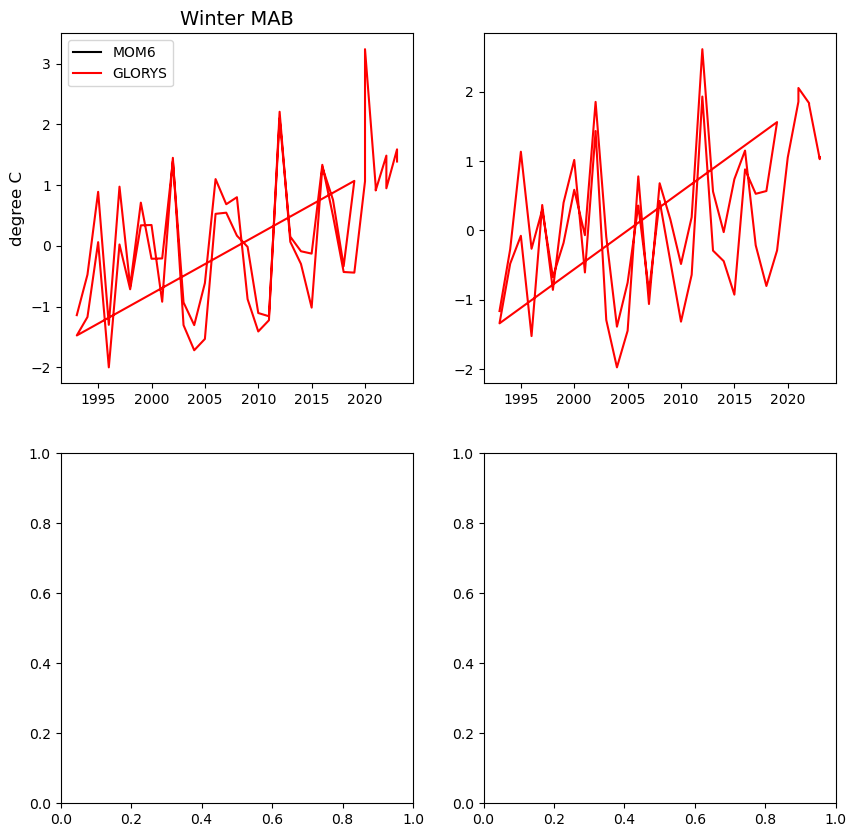

In [84]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [10,10])

df1 = BT_1993[(BT_1993.Var == 'Winter_bottom temp anomaly') & (BT_1993.EPU == 'MAB')]
df1a = BT_1993[(BT_1993.Var == 'Winter_Bottom Temp Anomaly') & (BT_1993.EPU == 'MAB')]
df2 = BT_1993[(BT_1993.Var == 'Spring_bottom temp anomaly') & (BT_1993.EPU == 'MAB')]
df2a = BT_1993[(BT_1993.Var == 'Spring_Bottom Temp Anomaly') & (BT_1993.EPU == 'MAB')]
df3 = BT_1993[(BT_1993.Var == 'Summer_bottom temp anomaly') & (BT_1993.EPU == 'MAB')]
df3a = BT_1993[(BT_1993.Var == 'Summer_Bottom Temp Anomaly') & (BT_1993.EPU == 'MAB')]
df4 = BT_1993[(BT_1993.Var == 'Fall_bottom temp anomaly') & (BT_1993.EPU == 'MAB')]
df4a = BT_1993[(BT_1993.Var == 'Fall_Bottom Temp Anomaly') & (BT_1993.EPU == 'MAB')]


ax[0,0].plot(df1.Time, df1.Value, c = 'k', label = 'MOM6')
ax[0,0].plot(df1a.Time, df1a.Value, c = 'r', label = 'GLORYS')
#ax[0,0].fill_between(np.arange(1959,1993), min(df1.Value)-0.5, max(df1.Value) +1, alpha=0.25, color = 'grey')
ax[0,0].set_title('Winter MAB', fontsize = 14)
ax[0,0].legend()
ax[0,0].set_ylabel('degree C', fontsize = 12)

ax[0,1].plot(df2.Time[:61], df2.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[0,1].plot(df2a.Time, df2a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[0,1].fill_between(np.arange(1959,1993), min(df2.Value)-0.5, max(df2.Value) +1, alpha=0.25, color = 'grey')
ax[0,1].set_title('Spring MAB', fontsize = 14)
ax[0,1].legend()

ax[1,0].plot(df3.Time[:61], df3.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[1,0].plot(df3a.Time, df3a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[1,0].fill_between(np.arange(1959,1993), min(df3.Value)-0.5, max(df3.Value) +1, alpha=0.25, color = 'grey')
ax[1,0].set_title('Summer MAB', fontsize = 14)
ax[1,0].legend()
ax[1,0].set_ylabel('degree C', fontsize = 12)

ax[1,1].plot(df4.Time[:61], df4.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[1,1].plot(df4a.Time, df4a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[1,1].fill_between(np.arange(1959,1993), min(df4.Value)-0.5, max(df4.Value) +1, alpha=0.25, color = 'grey')
ax[1,1].set_title('Fall MAB', fontsize = 14)
ax[1,1].legend()

In [120]:
BT

,Time,Value,EPU,Source,Var,Units,Unnamed: 0
0,1959,-1.359687,MAB,ROMS,Winter_Bottom Temp Anomaly,degrees C,NaN
1,1960,-0.683389,MAB,ROMS,Winter_Bottom Temp Anomaly,degrees C,NaN
2,1961,-1.455608,MAB,ROMS,Winter_Bottom Temp Anomaly,degrees C,NaN
3,1962,-0.981730,MAB,ROMS,Winter_Bottom Temp Anomaly,degrees C,NaN
4,1963,-1.316508,MAB,ROMS,Winter_Bottom Temp Anomaly,degrees C,NaN
...,...,...,...,...,...,...,...
1831,2023,1.055858,MAB,PSY,Spring_Bottom Temp Anomaly,degree C,1353.0
1832,2023,-0.200852,MAB,GLORYS,Summer_Bottom Temp Anomaly,degree C,1354.0
1833,2023,0.766353,MAB,PSY,Summer_Bottom Temp Anomaly,degree C,1355.0
1834,2023,1.589624,MAB,GLORYS,Winter_Bottom Temp Anomaly,degree C,1356.0


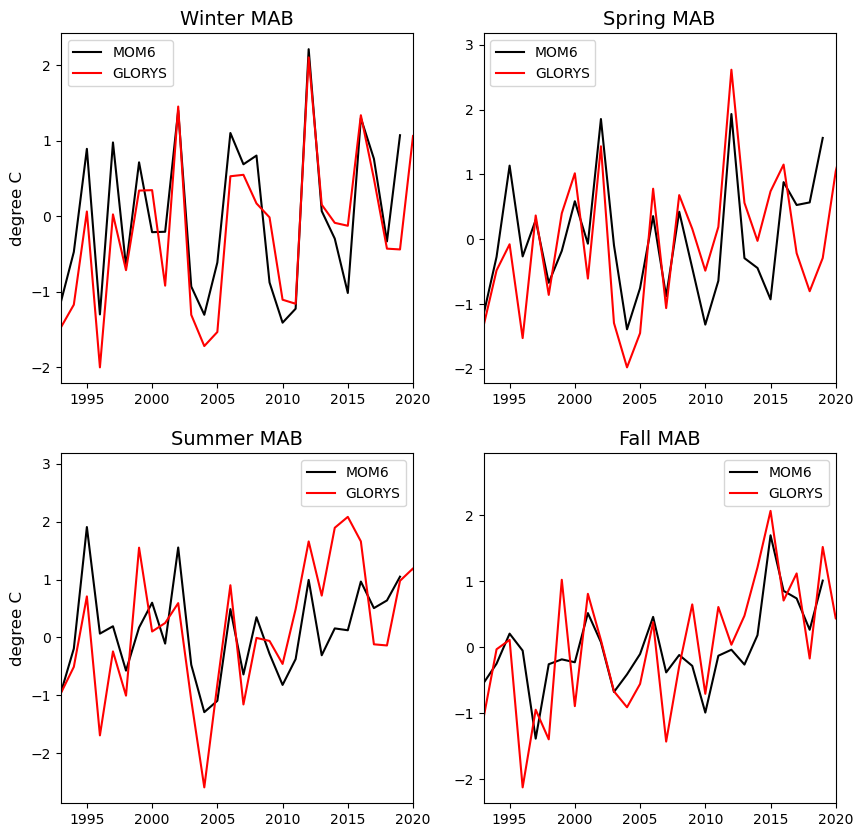

In [128]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [10,10])

df1 = BT[(BT.Var == 'Winter_Bottom Temp Anomaly') & (BT.EPU == 'MAB') & (BT.Source == 'MOM6')]
df1a = BT[(BT.Var == 'Winter_Bottom Temp Anomaly') & (BT.EPU == 'MAB')& (BT.Source == 'GLORYS')]
df2 = BT[(BT.Var == 'Spring_Bottom Temp Anomaly') & (BT.EPU == 'MAB') & (BT.Source == 'MOM6')]
df2a = BT[(BT.Var == 'Spring_Bottom Temp Anomaly') & (BT.EPU == 'MAB')& (BT.Source == 'GLORYS')]
df3 = BT[(BT.Var == 'Summer_Bottom Temp Anomaly') & (BT.EPU == 'MAB') & (BT.Source == 'MOM6')]
df3a = BT[(BT.Var == 'Summer_Bottom Temp Anomaly') & (BT.EPU == 'MAB')& (BT.Source == 'GLORYS')]
df4 = BT[(BT.Var == 'Fall_Bottom Temp Anomaly') & (BT.EPU == 'MAB') & (BT.Source == 'MOM6')]
df4a = BT[(BT.Var == 'Fall_Bottom Temp Anomaly') & (BT.EPU == 'MAB')& (BT.Source == 'GLORYS')]


ax[0,0].plot(df1.Time, df1.Value, c = 'k', label = 'MOM6')
ax[0,0].plot(df1a.Time, df1a.Value, c = 'r', label = 'GLORYS')
#ax[0,0].fill_between(np.arange(1959,1993), min(df1.Value)-0.5, max(df1.Value) +1, alpha=0.25, color = 'grey')
ax[0,0].set_title('Winter MAB', fontsize = 14)
ax[0,0].legend()
ax[0,0].set_ylabel('degree C', fontsize = 12)
ax[0,0].set_xlim(1993, 2020)

ax[0,1].plot(df2.Time[:61], df2.Value[:61], c = 'k', label = 'MOM6')
ax[0,1].plot(df2a.Time, df2a.Value, c = 'r', label = 'GLORYS')
ax[0,1].fill_between(np.arange(1959,1993), min(df2.Value)-0.5, max(df2.Value) +1, alpha=0.25, color = 'grey')
ax[0,1].set_title('Spring MAB', fontsize = 14)
ax[0,1].legend()
ax[0,1].set_xlim(1993, 2020)

ax[1,0].plot(df3.Time[:61], df3.Value[:61], c = 'k', label = 'MOM6')
ax[1,0].plot(df3a.Time, df3a.Value, c = 'r', label = 'GLORYS')
ax[1,0].fill_between(np.arange(1959,1993), min(df3.Value)-0.5, max(df3.Value) +1, alpha=0.25, color = 'grey')
ax[1,0].set_title('Summer MAB', fontsize = 14)
ax[1,0].legend()
ax[1,0].set_ylabel('degree C', fontsize = 12)
ax[1,0].set_xlim(1993, 2020)

ax[1,1].plot(df4.Time[:61], df4.Value[:61], c = 'k', label = 'MOM6')
ax[1,1].plot(df4a.Time, df4a.Value, c = 'r', label = 'GLORYS')
ax[1,1].fill_between(np.arange(1959,1993), min(df4.Value)-0.5, max(df4.Value) +1, alpha=0.25, color = 'grey')
ax[1,1].set_title('Fall MAB', fontsize = 14)
ax[1,1].set_xlim(1993, 2020)
ax[1,1].legend()

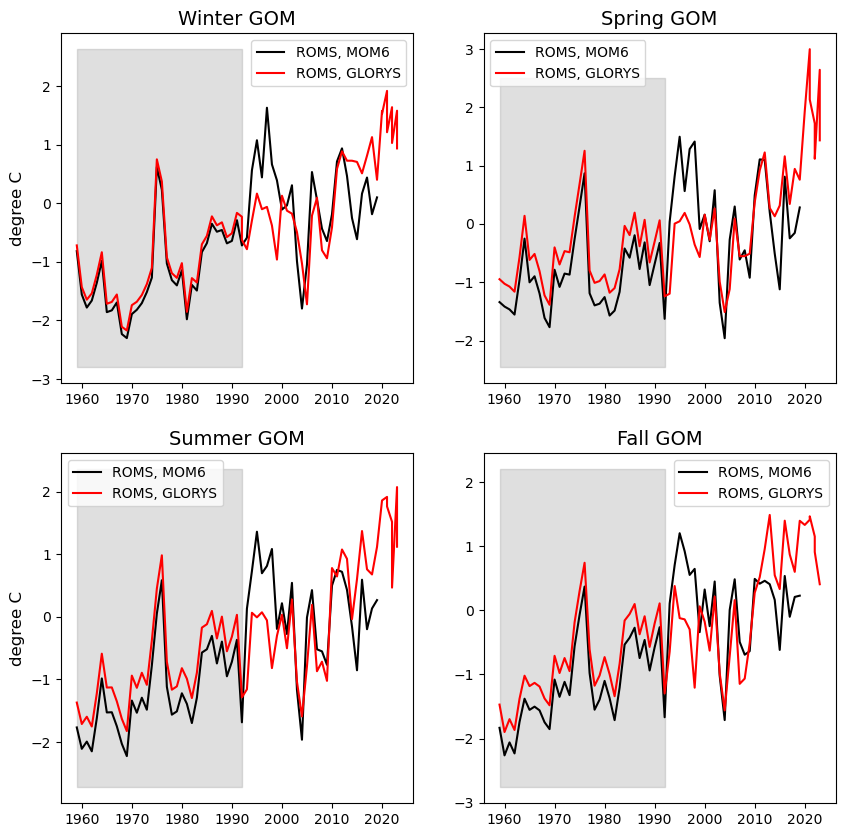

In [30]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [10,10])

df1 = BT[(BT.Var == 'Winter bottom temp anomaly roms_mom6') & (BT.EPU == 'GOM')]
df1a = BT[(BT.Var == 'Winter_Bottom Temp Anomaly') & (BT.EPU == 'GOM')]
df2 = BT[(BT.Var == 'Spring bottom temp anomaly roms_mom6') & (BT.EPU == 'GOM')]
df2a = BT[(BT.Var == 'Spring_Bottom Temp Anomaly') & (BT.EPU == 'GOM')]
df3 = BT[(BT.Var == 'Summer bottom temp anomaly roms_mom6') & (BT.EPU == 'GOM')]
df3a = BT[(BT.Var == 'Summer_Bottom Temp Anomaly') & (BT.EPU == 'GOM')]
df4 = BT[(BT.Var == 'Fall bottom temp anomaly roms_mom6') & (BT.EPU == 'GOM')]
df4a = BT[(BT.Var == 'Fall_Bottom Temp Anomaly') & (BT.EPU == 'GOM')]


ax[0,0].plot(df1.Time, df1.Value, c = 'k', label = 'ROMS, MOM6')
ax[0,0].plot(df1a.Time, df1a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[0,0].fill_between(np.arange(1959,1993), min(df1.Value)-0.5, max(df1.Value) +1, alpha=0.25, color = 'grey')
ax[0,0].set_title('Winter GOM', fontsize = 14)
ax[0,0].legend()
ax[0,0].set_ylabel('degree C', fontsize = 12)

ax[0,1].plot(df2.Time[:61], df2.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[0,1].plot(df2a.Time, df2a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[0,1].fill_between(np.arange(1959,1993), min(df2.Value)-0.5, max(df2.Value) +1, alpha=0.25, color = 'grey')
ax[0,1].set_title('Spring GOM', fontsize = 14)
ax[0,1].legend()

ax[1,0].plot(df3.Time[:61], df3.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[1,0].plot(df3a.Time, df3a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[1,0].fill_between(np.arange(1959,1993), min(df3.Value)-0.5, max(df3.Value) +1, alpha=0.25, color = 'grey')
ax[1,0].set_title('Summer GOM', fontsize = 14)
ax[1,0].legend()
ax[1,0].set_ylabel('degree C', fontsize = 12)

ax[1,1].plot(df4.Time[:61], df4.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[1,1].plot(df4a.Time, df4a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[1,1].fill_between(np.arange(1959,1993), min(df4.Value)-0.5, max(df4.Value) +1, alpha=0.25, color = 'grey')
ax[1,1].set_title('Fall GOM', fontsize = 14)
ax[1,1].legend()

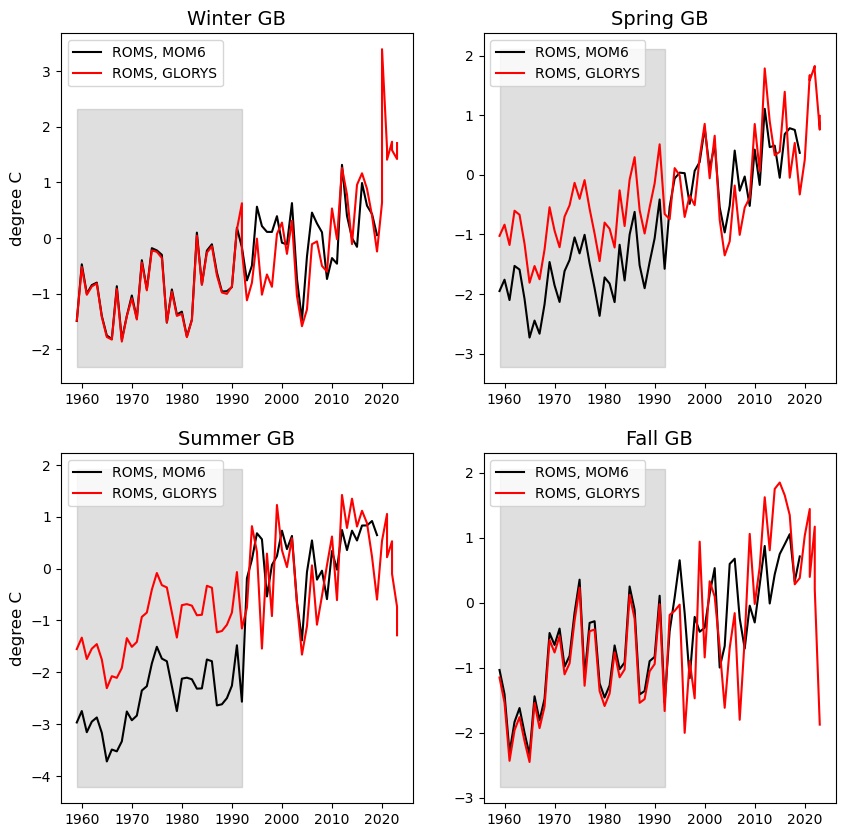

In [31]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = [10,10])

df1 = BT[(BT.Var == 'Winter bottom temp anomaly roms_mom6') & (BT.EPU == 'GB')]
df1a = BT[(BT.Var == 'Winter_Bottom Temp Anomaly') & (BT.EPU == 'GB')]
df2 = BT[(BT.Var == 'Spring bottom temp anomaly roms_mom6') & (BT.EPU == 'GB')]
df2a = BT[(BT.Var == 'Spring_Bottom Temp Anomaly') & (BT.EPU == 'GB')]
df3 = BT[(BT.Var == 'Summer bottom temp anomaly roms_mom6') & (BT.EPU == 'GB')]
df3a = BT[(BT.Var == 'Summer_Bottom Temp Anomaly') & (BT.EPU == 'GB')]
df4 = BT[(BT.Var == 'Fall bottom temp anomaly roms_mom6') & (BT.EPU == 'GB')]
df4a = BT[(BT.Var == 'Fall_Bottom Temp Anomaly') & (BT.EPU == 'GB')]


ax[0,0].plot(df1.Time, df1.Value, c = 'k', label = 'ROMS, MOM6')
ax[0,0].plot(df1a.Time, df1a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[0,0].fill_between(np.arange(1959,1993), min(df1.Value)-0.5, max(df1.Value) +1, alpha=0.25, color = 'grey')
ax[0,0].set_title('Winter GB', fontsize = 14)
ax[0,0].legend()
ax[0,0].set_ylabel('degree C', fontsize = 12)

ax[0,1].plot(df2.Time[:61], df2.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[0,1].plot(df2a.Time, df2a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[0,1].fill_between(np.arange(1959,1993), min(df2.Value)-0.5, max(df2.Value) +1, alpha=0.25, color = 'grey')
ax[0,1].set_title('Spring GB', fontsize = 14)
ax[0,1].legend()

ax[1,0].plot(df3.Time[:61], df3.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[1,0].plot(df3a.Time, df3a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[1,0].fill_between(np.arange(1959,1993), min(df3.Value)-0.5, max(df3.Value) +1, alpha=0.25, color = 'grey')
ax[1,0].set_title('Summer GB', fontsize = 14)
ax[1,0].legend()
ax[1,0].set_ylabel('degree C', fontsize = 12)

ax[1,1].plot(df4.Time[:61], df4.Value[:61], c = 'k', label = 'ROMS, MOM6')
ax[1,1].plot(df4a.Time, df4a.Value, c = 'r', label = 'ROMS, GLORYS')
ax[1,1].fill_between(np.arange(1959,1993), min(df4.Value)-0.5, max(df4.Value) +1, alpha=0.25, color = 'grey')
ax[1,1].set_title('Fall GB', fontsize = 14)
ax[1,1].legend()

In [32]:
BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'MAB')& (BT.Source == 'MOM6')]

,Time,Value,EPU,Source,Var,Units,Unnamed: 0
732,1993,10.074950,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
733,1994,10.730495,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
734,1995,12.062013,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
735,1996,10.639745,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
736,1997,11.047755,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
737,1998,10.485538,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
738,1999,11.157024,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
739,2000,11.213891,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
740,2001,11.060874,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN
741,2002,12.247596,MAB,MOM6,Annual_Bottom Temp,degrees C,NaN


Text(0.5, 1.0, 'Annual BT GOM')

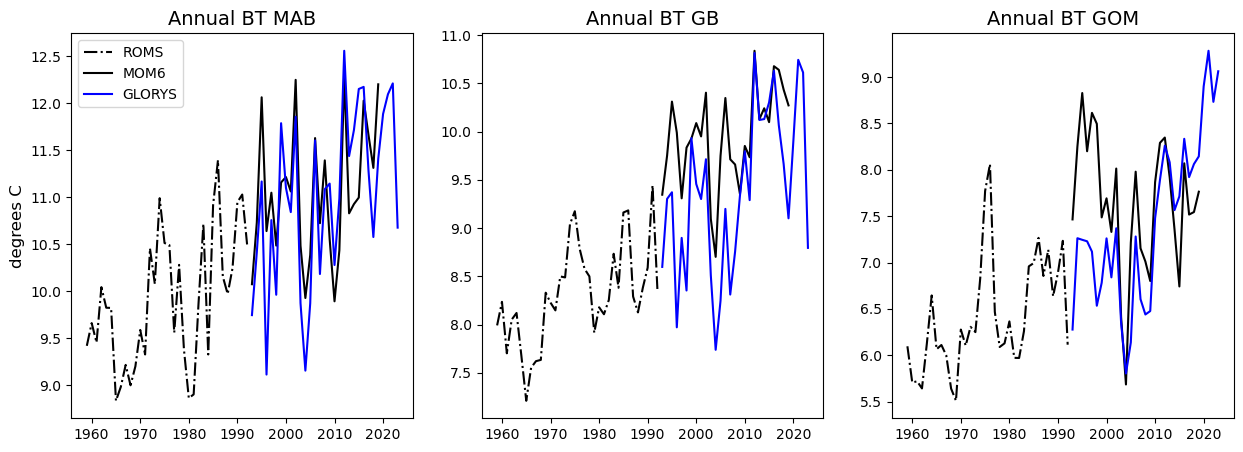

In [36]:
fig, ax = plt.subplots(ncols = 3, figsize = [15,5])

df1 = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'MAB') & (BT.Source == 'ROMS')]
df1a = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'MAB') & (BT.Source == 'MOM6')]
df1b = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'MAB') & (BT.Source == 'GLORYS')]
df1c = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'MAB') & (BT.Source == 'PSY')]

df2 = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'GB') & (BT.Source == 'ROMS')]
df2a = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'GB') & (BT.Source == 'MOM6')]
df2b = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'GB') & (BT.Source == 'GLORYS')]
df2c = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'GB') & (BT.Source == 'PSY')]

df3 = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'GOM') & (BT.Source == 'ROMS')]
df3a = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'GOM') & (BT.Source == 'MOM6')]
df3b = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'GOM') & (BT.Source == 'GLORYS')]
df3c = BT[(BT.Var == 'Annual_Bottom Temp') & (BT.EPU == 'GOM') & (BT.Source == 'PSY')]

ax[0].plot(df1.Time, df1.Value, label = 'ROMS', c = 'k', linestyle = '-.')
ax[0].plot(df1a.Time, df1a.Value, label = 'MOM6',c = 'k')
ax[0].plot(df1b.Time, df1b.Value, label = 'GLORYS', c = 'b')
ax[0].legend()
ax[0].set_title('Annual BT MAB', fontsize = 14)
ax[0].set_ylabel('degrees C', fontsize = 12)

ax[1].plot(df2.Time, df2.Value, label = 'ROMS', c = 'k', linestyle = '-.')
ax[1].plot(df2a.Time, df2a.Value, label = 'MOM6', c = 'k')
ax[1].plot(df2b.Time, df2b.Value, label = 'GLORYS', c = 'b')
#ax[1].legend()
ax[1].set_title('Annual BT GB', fontsize = 14)

ax[2].plot(df3.Time, df3.Value, label = 'ROMS', c = 'k', linestyle = '-.')
ax[2].plot(df3a.Time, df3a.Value, label = 'MOM6',c = 'k')
ax[2].plot(df3b.Time, df3b.Value, label = 'GLORYS',c = 'b')
#ax[2].legend()
ax[2].set_title('Annual BT GOM', fontsize = 14)

In [45]:
BT[BT.Time > 1992].drop('Unnamed: 0', axis =1)

,Time,Value,EPU,Source,Var,Units
34,1993,-1.140077,MAB,MOM6,Winter bottom temp anomaly roms_mom6,degrees C
35,1994,-0.472983,MAB,MOM6,Winter bottom temp anomaly roms_mom6,degrees C
36,1995,0.890744,MAB,MOM6,Winter bottom temp anomaly roms_mom6,degrees C
37,1996,-1.299204,MAB,MOM6,Winter bottom temp anomaly roms_mom6,degrees C
38,1997,0.975538,MAB,MOM6,Winter bottom temp anomaly roms_mom6,degrees C
...,...,...,...,...,...,...
1831,2023,1.055858,MAB,PSY,Spring_Bottom Temp Anomaly,degree C
1832,2023,-0.200852,MAB,GLORYS,Summer_Bottom Temp Anomaly,degree C
1833,2023,0.766353,MAB,PSY,Summer_Bottom Temp Anomaly,degree C
1834,2023,1.589624,MAB,GLORYS,Winter_Bottom Temp Anomaly,degree C


In [42]:
BT.columns

Index(['Time', 'Value', 'EPU', 'Source', 'Var', 'Units', 'Unnamed: 0'], dtype='object')